In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr
import math

In [2]:
def convert_str_2_float_simple(x):
    y=0
    try:
        y=float(x)
    except:
        y=0#np.NAN

def convert_str_2_float(x):
    y=0
    try:
        y=float(x.replace(",","")[1:])
    except:
        y=0#np.NAN
    return y
def conv_str_2_float(x):
    y=0
    try:
        y=float(x.replace(",","")[1:])
    except:
        y=np.NAN
    return y
def convert_str_2_float2(x):
    y=0
    try:
        y=float(x.replace(",","")[:-2])
    except:
        y=0#np.NAN
    return y

def replace_nan(x):
    y=0
    if math.isnan(x):
        return 9
    else:
        try:
            y=float(x)
        except:
            y=9
        return y


Project Motivation and Details
Data
For this project, you will pick a dataset. Inspired by Robert, there are a few public datasets from AirBnB available below, but you may also choose a dataset similar to what was used in the lessons, or an entirely different dataset. Using your dataset, you will choose 3 questions you aspire to answer from the data.

Key Steps for Project
Feel free to be creative with your solutions, but do follow the CRISP-DM process in finding your solutions.

1. Pick a dataset.

2. Pose at least three questions related to business or real-world applications of how the data could be used.

3. Create a Jupyter Notebook, using any associated packages you'd like, to:

- Prepare data:
    - Gather necessary data to answer your questions
    - Handle categorical and missing data
    - Provide insight into the methods you chose and why you chose them
- Analyze, Model, and Visualize
    - Provide a clear connection between your business questions and how the data answers them.
    
4. Communicate your business insights:
- Create a Github repository to share your code and data wrangling/modeling techniques, with a technical audience in mind
- Create a blog post to share your questions and insights with a non-technical audience
- Your deliverables will be a Github repo and a blog post. Use the rubric here to assist in successfully completing this project!

In [3]:
cal=pd.read_csv("data/calendar.csv")
lis=pd.read_csv("data/listings.csv")
rev=pd.read_csv("data/reviews.csv")

print(cal.columns)
print(lis.columns)
print(rev.columns)

print(cal.shape)
print(lis.shape)
print(rev.shape)

Index(['listing_id', 'date', 'available', 'price'], dtype='object')
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates'

In [217]:
lis[(lis.room_type=='Private room')][['host_listings_count','host_total_listings_count']]# .unique() # & (lis.guests_included)]

,host_listings_count,host_total_listings_count
5,1.0,1.0
6,1.0,1.0
7,5.0,5.0
8,1.0,1.0
16,1.0,1.0
...,...,...
3789,2.0,2.0
3791,1.0,1.0
3798,2.0,2.0
3799,1.0,1.0


Data source: 
survey data
- https://www.kaggle.com/datasets/airbnb/seattle

geographical data:
- https://data-seattlecitygis.opendata.arcgis.com/datasets/city-clerk-neighborhoods/explore?location=47.614536%2C-122.336950%2C12.40

Questions:
1. What is the typical deviation of each accomodity's price from its list price by area?
2. Is there a relationship between host response rate and review scores value?
3. Does the rating depend on the reviewer's and host's gender?

1. How large is the deviation of each accomodity's price from its list price by area?

In [177]:
# define new dataframe "cal_lis" as a merge of "cal" and "lis"

cal_lis=pd.merge(cal,lis,how='inner',left_on='listing_id',right_on='id')

In [178]:
# change prices into numerical format

cal_lis['available_price']=cal_lis.price_x.apply(conv_str_2_float) # available price 
cal_lis['list_price']=cal_lis.price_y.apply(conv_str_2_float) # listing price
# cal_lis['list_price']=cal_lis.monthly_price.apply(conv_str_2_float) # listing price

cal_lis.drop(columns=['price_x','price_y'],inplace=True)

In [179]:

# Number of apartments per neighbourhood
apartments_per_neighbourhood=lis[['neighbourhood']].groupby(['neighbourhood'],as_index=False).value_counts()
apartments_per_neighbourhood.sort_values(by='count',inplace=True,ascending=False)
apartments_per_neighbourhood.rename(columns={"count": "listings"},inplace=True)

# average list price "avg_list_price" and average daily deviation from an accomodation's list price "avg_deviation_from_accomodations_list_price"

# average over each accomodation
temp=cal_lis[['listing_id','available_price','list_price', 'neighbourhood']].copy()
temp['deviation_from_list_price']=temp['available_price']-temp['list_price']
temp=temp.groupby(['listing_id', 'neighbourhood'],as_index=False).mean()
temp.rename(columns={"deviation_from_list_price": "avg_deviation_from_accomodations_list_price"},inplace=True)

# average over all accomodations per neighbourhood
temp=temp[['list_price','avg_deviation_from_accomodations_list_price','neighbourhood']].groupby(['neighbourhood'],as_index=False).mean()[['list_price','avg_deviation_from_accomodations_list_price','neighbourhood']]
prices_per_neighbourhood=pd.merge(apartments_per_neighbourhood,temp,on="neighbourhood")
prices_per_neighbourhood.sort_values(by=['avg_deviation_from_accomodations_list_price', "listings"],inplace=True,ascending=False)

prices_per_neighbourhood.rename(columns={"list_price": "average list price", "avg_deviation_from_accomodations_list_price" : "typical deviation from accomodations list price"},inplace=True)

prices_per_neighbourhood.reset_index()
prices_per_neighbourhood.iloc[0:15].style.hide(axis="index")


neighbourhood,listings,average list price,typical deviation from accomodations list price
Pike Market,2,92.000000,100.477140
Windermere,10,174.700000,53.754500
Central Business District,81,163.728395,39.767041
Pinehurst,3,138.000000,37.631818
Belltown,204,166.627451,32.376357
Interbay,7,102.000000,20.991399
Pike Place Market,39,175.512821,18.685403
Magnolia,55,176.000000,16.497812
South Lake Union,21,154.142857,14.897705
Alki,23,196.652174,14.862521


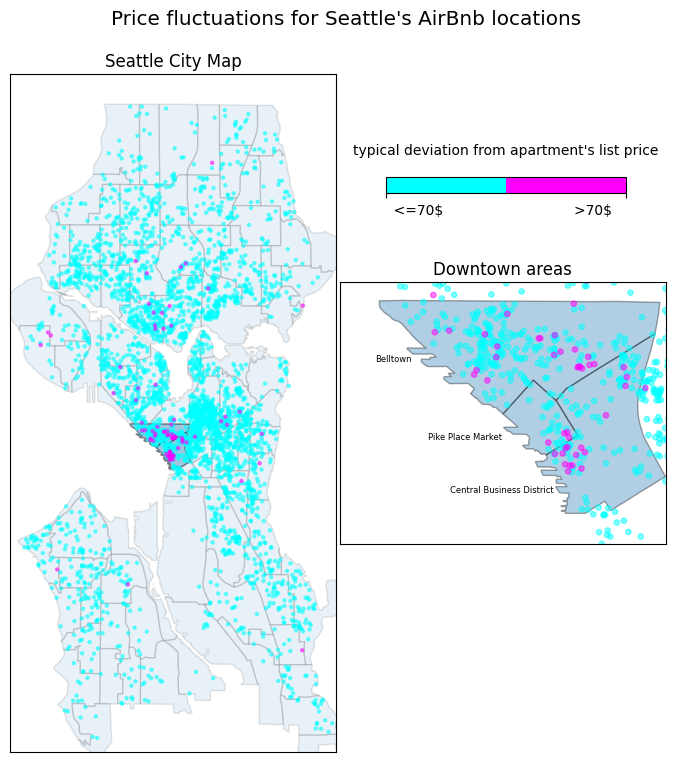

In [98]:

# create view
thresh_value=100

df0=cal_lis[['listing_id','available_price','list_price', 'latitude', 'longitude']].copy().groupby(['listing_id','list_price', 'latitude', 'longitude'],as_index=False).mean()
df0['avg_price_deviation']=df0['available_price']-df0['list_price']
df0.dropna(subset=['avg_price_deviation'],inplace=True)
df0['color']=df0.avg_price_deviation.apply(lambda x : (x>thresh_value))
df0.sort_values(by=['color'],ascending=True,inplace=True)


# initialize plot
plt.rcParams['figure.figsize'] = [8,8]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(left=0.08,right=0.9,bottom=0.05, top=0.9,hspace=-0.32,wspace=0.01)

# title
plt.suptitle('Price fluctuations for Seattle\'s AirBnb locations',fontsize='x-large')

# define color map
N_col=2 # number of discrete colors
cmap = plt.get_cmap('cool', N_col)  # color change defined through "jet" keyword

# create ScalarMappable
norm = matplotlib.colors.Normalize(vmin=0, vmax=1) # defines min and max values of the data that map to min and max values of the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])




# left plot
plt.subplot(121)
plt.title('Seattle City Map',fontsize='large')
ax=ax1

# x,y-range
ax.set_xlim((-122.425,-122.25))  # longitude range
ax.set_ylim((47.5,47.745))       # latitude range
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# load neighbourhoods; source: https://data-seattlecitygis.opendata.arcgis.com/datasets/city-clerk-neighborhoods/explore?location=47.614536%2C-122.336950%2C12.40
df = geopandas.read_file(r".\City_Clerk_Neighborhoods.shx")
df.plot(ax=ax, alpha=0.1, edgecolor="k")
df2=df[(df.S_HOOD=="Central Business District") | (df.S_HOOD=="Belltown") | (df.S_HOOD=="Pike-Market")]
df2.plot(ax=ax, alpha=0.35, edgecolor="k")

# load AirBnb listings
ax.scatter(df0.longitude,df0.latitude,c=df0.color.values,cmap=cmap, alpha=0.5,s=len(df0.color)*[5])



# right plot
plt.subplot(122)
plt.title('Downtown areas',fontsize='large')
ax = ax2

# x,y-range
ax.set_xlim((-122.365,-122.328)) # longitude range
ax.set_ylim((47.6,47.62))        # latitude range
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# load neighbourhoods
df = geopandas.read_file(r".\City_Clerk_Neighborhoods.shx")
df2=df[(df.S_HOOD=="Central Business District") | (df.S_HOOD=="Belltown") | (df.S_HOOD=="Pike-Market")]
df2.plot(ax=ax, alpha=0.35, edgecolor="k")

# annotate neighbourhoods
ax.text(-122.361, 47.614, r'Belltown', fontsize=6)
ax.text(-122.355, 47.608, r'Pike Place Market', fontsize=6)
ax.text(-122.3525, 47.604, r'Central Business District', fontsize=6)

# load AirBnb listings
ax.scatter(df0.longitude,df0.latitude,c=df0.color.values,cmap=cmap, alpha=0.5,s=len(df0)*[15])

# load color bar
ax3=plt.axes([0.55,0.75,0.3,0.02])
testus=fig.colorbar(sm, ticks=np.linspace(0, 1, N_col),cax=ax3,orientation='horizontal')
testus.ax.set_xticklabels(['               <=70$','>70$               '])
testus.ax.set_xlabel('typical deviation from apartment\'s list price', rotation=0,labelpad=-53)

# plot
plt.show()

2. Is there a relationship between host response rate and review scores value?

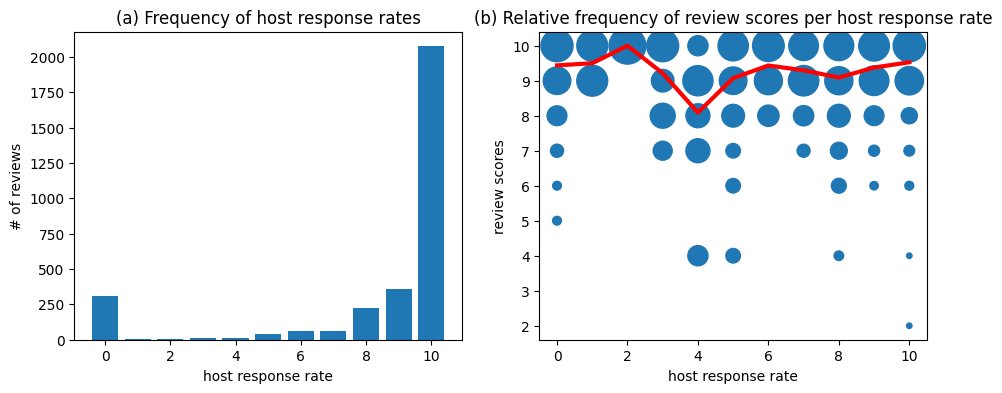

In [201]:
# Correlation between host_response_rate and review scores value?

# append column with host response rate in numerical values
lis['host_response_rate_num']=lis['host_response_rate'].apply(convert_str_2_float2)

tempi0=lis[['host_response_rate_num','review_scores_value']].copy()
tempi0.dropna(inplace=True,axis=0)
tempi1=tempi0.groupby(['host_response_rate_num'],as_index=False).mean().sort_values(by=['host_response_rate_num'],ascending=True)
tempi0=tempi0[['host_response_rate_num']].groupby(['host_response_rate_num'],as_index=False).value_counts(dropna=True).copy()
tempi0.rename(columns={"count": "counts_per_host_response_rate"},inplace=True)





tempi=lis[['host_response_rate_num','review_scores_value']].copy()
tempi.dropna(inplace=True,axis=0)
tempi=tempi.groupby(['host_response_rate_num','review_scores_value'],as_index=False).value_counts(dropna=True).copy()

tempi=pd.merge(tempi,tempi0,on="host_response_rate_num")



plt.rcParams['figure.figsize'] = [11,4]
# initialize plot
# plt.rcParams['figure.figsize'] = [8,8]

fig, (ax1, ax2) = plt.subplots(1, 2)

# fig.subplots_adjust(left=0.08,right=0.9,bottom=0.05, top=0.9,hspace=-0.32,wspace=0.01)
# plt.suptitle("Histogram of host response rate and review scores value")
plt.subplot(121)

plt.title("(a) Frequency of host response rates")
plt.xlabel('host response rate')
plt.ylabel('# of reviews')
plt.bar(tempi0.host_response_rate_num,tempi0.counts_per_host_response_rate)# , linestyle = '-', linewidth = '3',color="r")



plt.subplot(122)

plt.title("(b) Relative frequency of review scores per host response rate")
plt.xlabel('host response rate')
plt.ylabel('review scores')

# Histogram of host response rate and review scores value

plt.scatter(tempi.host_response_rate_num,tempi.review_scores_value ,s=700*np.sqrt(tempi['count']/tempi['counts_per_host_response_rate']))


ypoints = tempi1.review_scores_value# np.array([0,1,2,3,4,5,6,7,8,9,10])
# ypoints=tempi.groupby(['host_response_rate_num']).mean()
plt.plot(ypoints, linestyle = '-', linewidth = '3',color="r")


plt.show()
# print(tempi0.counts_per_host_response_rate)# .groupby(['host_response_rate_num']).mean())


One can see that the distribution of data among host response rate and review scores value is not revealing an intuitive monotonous increasing relationship between both qantities.
At high host response rate, one can recognize an expected high review scores value.
However, the same holds at low host response rates.
Intermediate response rates, on the contrary, reveal lower review scores values.

A possible explanation for this non-intuitive behavior might lie in the fact that cases at which no host was requested form the majority
of cases with host response rate equals zero.
Even if there is a demand with less priority, then there is little reason for a quick response and guests are still satisfied.
This can be seen at host response rates being one or two. But these cases are rare and statistics is accordingly bad.
Once there is a fundamental reason for a quick host response, one highly values if this becomes true.
But if there is a fundamental reason and there is a weak response rate (about 3 to 5), reviewers will takes this behavior negatively into account.


In [ ]:
# Pearson correlation coefficient
temp=lis[['host_response_rate_num','review_scores_value']].copy()
temp.dropna(inplace=True,axis=0)

print("Pearson coefficient: ",pearsonr(temp.host_response_rate_num,temp.review_scores_value)[0])
print("Pearson coefficient: ",pearsonr(temp[temp.host_response_rate_num<5].host_response_rate_num,temp[temp.host_response_rate_num<5].review_scores_value)[0])
print("Pearson coefficient: ",pearsonr(temp[temp.host_response_rate_num>4].host_response_rate_num,temp[temp.host_response_rate_num>4].review_scores_value)[0])

With respect to the outcome it indicates that there is a slight correlation between host response rate and review scores value.
At a first glance it is intuitive that more communication with the host leads to higher grades.

However, more communication may also indicate that trouble has appeared.

The correlation for response rates <5 is negative
But if trouble appeared an there is no communication possible, the rating is probably lower without communication.

Therefore, a slight corelation makes sense.


3. Does the rating depend on the reviewer's and host's gender?

In [220]:
import gender_guesser.detector as gender
d = gender.Detector()
y=pd.merge(rev,lis,how='inner',left_on='listing_id',right_on='id')

# add gender attributes
y['reviewer_gender']=y['reviewer_name'].apply(d.get_gender)
y['host_gender']=y['host_name'].apply(d.get_gender)

In [221]:
mm=y.review_scores_value[(y['reviewer_gender']=="male") & (y['host_gender']=="male")].mean(skipna=True)
mf=y.review_scores_value[(y['reviewer_gender']=="male") & (y['host_gender']=="female")].mean(skipna=True)
fm=y.review_scores_value[(y['reviewer_gender']=="female") & (y['host_gender']=="male")].mean(skipna=True)
ff=y.review_scores_value[(y['reviewer_gender']=="female") & (y['host_gender']=="female")].mean(skipna=True)

mmp=y.review_scores_value[(y['reviewer_gender']=="male") & (y['host_gender']=="male") & (y.room_type=='Private room')].mean(skipna=True)
mfp=y.review_scores_value[(y['reviewer_gender']=="male") & (y['host_gender']=="female") & (y.room_type=='Private room')].mean(skipna=True)
fmp=y.review_scores_value[(y['reviewer_gender']=="female") & (y['host_gender']=="male") & (y.room_type=='Private room')].mean(skipna=True)
ffp=y.review_scores_value[(y['reviewer_gender']=="female") & (y['host_gender']=="female") & (y.room_type=='Private room')].mean(skipna=True)

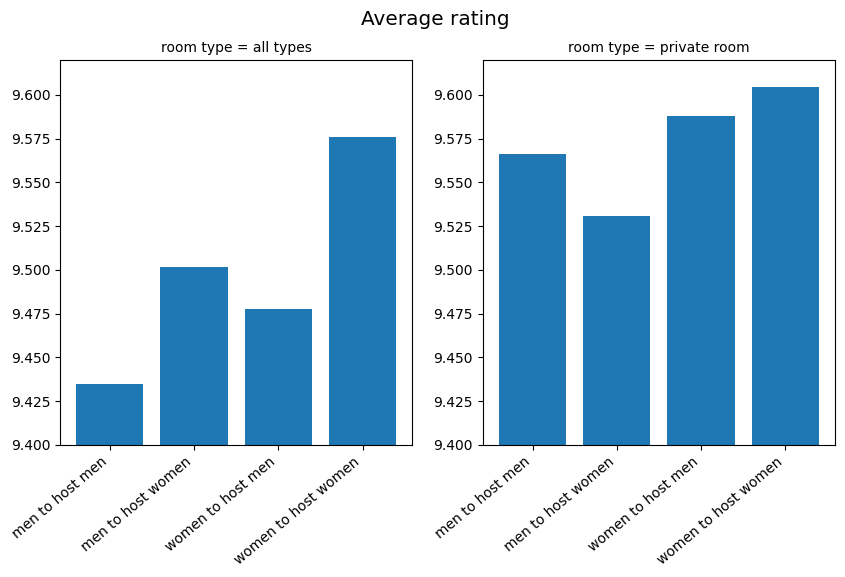

In [222]:
names = ['men to host men', 'men to host women', 'women to host men', 'women to host women']
values = [mm,mf,fm,ff]
valuesp = [mmp,mfp,fmp,ffp]

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.bar(names, values)
ax = plt.gca()
ax.set_ylim([9.4, 9.62])
ax.set_xticks(names)
ax.set_xticklabels(names, rotation=40,ha='right',va='top')
plt.title('room type = all types',fontsize='medium')

plt.subplot(122)
plt.bar(names, valuesp)
ax = plt.gca()
ax.set_ylim([9.4, 9.62])
ax.set_xticks(names)
ax.set_xticklabels(names, rotation=40 ,ha='right',va='top')
plt.title('room type = private room',fontsize='medium')

plt.suptitle('Average rating',fontsize='x-large')

plt.show()

Outcome:
Women and men give host women higher grades than if evaluating host men.
Men evaluate hosts with opposite sex higher than women do.
The highest average scores are yield if women evaluate host women.

However, when the stay is in a private room, then men evaluate host women lower than host men.
Hereby, the evaluations of women are always better than those by men, but still, women vote host women best.

Discussion:
Besides the general difference in rating among men and women, the different rating behavior in men for 
booking a private room suggests that men tend to feel a bit uncomfortable when it comes to sharing the apartment
with a female host.



In [219]:
mmpg=y.review_scores_value[(y['reviewer_gender']=="male") & (y['host_gender']=="male") & (y.room_type=='Private room') & (y.host_listings_count==1) ].mean(skipna=True)
mfpg=y.review_scores_value[(y['reviewer_gender']=="male") & (y['host_gender']=="female") & (y.room_type=='Private room') & (y.host_listings_count==1)].mean(skipna=True)
fmpg=y.review_scores_value[(y['reviewer_gender']=="female") & (y['host_gender']=="male") & (y.room_type=='Private room') & (y.host_listings_count==1)].mean(skipna=True)
ffpg=y.review_scores_value[(y['reviewer_gender']=="female") & (y['host_gender']=="female") & (y.room_type=='Private room') & (y.host_listings_count==1)].mean(skipna=True)
print([mmpg,mfpg,fmpg,ffpg])
print([mmp,mfp,fmp,ffp])

[9.568078175895765, 9.554259634888439, 9.57306073361395, 9.630912162162161]
[9.566037735849056, 9.530696121243258, 9.587682038834952, 9.604331975123312]
